In [2]:
pip install undetected-chromedriver bs4 nltk transformers tensorflow numpy scipy gensim num2words

Note: you may need to restart the kernel to use updated packages.


DEPRECATION: textract 1.6.5 has a non-standard dependency specifier extract-msg<=0.29.*. pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of textract or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063


In [3]:
import requests

# Webscraping Packages
from bs4 import BeautifulSoup
import undetected_chromedriver as uc
from selenium.webdriver.common.by import By


import time

# Regex Package
import re



# NLP packages
import spacy
import nltk
from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize


# Package for tabular data 
import pandas as pd

# Package to count the frequency
from collections import Counter

# Neural Network packages
import tensorflow as tf


# Module to save the model
import pickle

nltk.download('stopwords')
nlp = spacy.load('en_core_web_sm')


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Poorn\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
all_texts = []
def fetch_ipl_data():
    global all_texts
    driver = uc.Chrome(headless=False,use_subprocess=True)
    year = 2022
    # Since the comments are only available after year 2022 and until the current year 2024
    while year < 2025:
        endpoint = f"/{year}"
        if year == 2024:
            endpoint = f'/'
        url = f"https://www.iplt20.com/matches/results{endpoint}"
        # Requesting for all years results.
        driver.get(url)
        time.sleep(5)

        # all the links of each match is stored 
        all_matches = [each.get_attribute('href') for each in driver.find_elements(By.CSS_SELECTOR,'.vn-matchBtn')]

        total_number_of_matches = len(driver.find_elements(By.CSS_SELECTOR,'.vn-matchBtn'))
        print(f'total matches : {total_number_of_matches}')

        # iterating all the matches
        for index,match in enumerate(all_matches):
            driver.get(match)
            time.sleep(5)
            
            # The teams information
            teams = driver.find_elements(By.CSS_SELECTOR,'.commentaryTitleWrap .ap-inner-tb-click.ng-binding.ng-scope')
            
            for team in teams:
                team.click()
                time.sleep(5)
                for each in driver.find_elements(By.CSS_SELECTOR,'.ballWrapper.ng-scope'):
                    over_and_score = (each.find_element(By.CSS_SELECTOR,'div p').text).split()
                    try:
                        over = over_and_score[0]
                        score = over_and_score[1]
                        comment_with_bolwer_and_batsmen = (each.find_element(By.CSS_SELECTOR,'.cmdText.ng-scope').text).split('\n')
                        re_match = re.search("([\w\s]+)bowling to([\w\s]+)",comment_with_bolwer_and_batsmen[0])
                        
                        bowler = re_match.group(1)
                        batsmen = re_match.group(2)
                        comment = ' '.join(comment_with_bolwer_and_batsmen[1:])
                        all_texts.append((over,score,batsmen,bowler,comment))
            
                    except:
                        pass
                        
            
        driver.quit()
        df = pd.DataFrame(all_texts,columns=["over","score",'batsmen','bowler',"comment"])
        year += 1
    return df
# df = fetch_ipl_data()
# df.to_csv('ipl_2024-04-21.csv')

In [5]:
df = pd.read_csv('ipl_2024-04-21.csv').drop(columns=['Unnamed: 0'])
df2 = pd.read_csv('ipl_2024-04-19.csv').drop(columns=['Unnamed: 0'])


In [6]:
print('The shape of the dataframe is:',df.shape)
df.head(5)


The shape of the dataframe is: (13430, 5)


over score          batsmen        bowler  \
0  19.6     2    Shahbaz Ahmed   Obed McCoy    
1  19.5     0    Shahbaz Ahmed   Obed McCoy    
2  19.4     0    Shahbaz Ahmed   Obed McCoy    
3  19.3     1   Josh Hazlewood   Obed McCoy    
4  19.2     0   Josh Hazlewood   Obed McCoy    

                                             comment  
0  Short of good length ball, pitching outside of...  
1  Full toss ball, on off stump, Shahbaz Ahmed pl...  
2  Good length ball, pitching outside off stump, ...  
3  Full length ball, pitching on off stump, Josh ...  
4  Full length ball, pitching outside off stump, ...

In [7]:


df = pd.concat([df2,df])
df.drop_duplicates(inplace=True)
df.dropna(inplace=True)


indexes = df[df['comment'].duplicated() & df['over'].duplicated() & df['batsmen'].duplicated()].index
df.drop(indexes,inplace=True,axis=0)
df['batsmen'] = df['batsmen'].apply(lambda x: x.strip())
df['score'].value_counts()

# 
four_text = ' '.join(df['comment'][df.score == '4'].apply(lambda x:str(x)).to_list())
six_text = ' '.join(df['comment'][df.score == '6'].apply(lambda x:str(x)).to_list())


In [8]:
def create_frequency_words(text):
    doc = nlp(text)

    
    counter_freq = Counter(token.text for token in doc if not token.is_stop if not token.is_punct if not token.is_space)
    sorted_freq = sorted(counter_freq.items(),key=lambda x: x[1],reverse=True)[5:-5]
    return sorted_freq

In [9]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def create_word_cloud(sorted_freq,title):
    all_text = ' '.join([each[0] for each in sorted_freq if not each[0].startswith('pic.twitter') and not each[0].startswith('https:')])

    # Create a WordCloud object
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_text)

    # Display the WordCloud
    plt.figure(figsize=(10, 5))
    plt.title(title)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()


In [10]:
four_freq = create_frequency_words(four_text)
six_freq =  create_frequency_words(six_text)

In [11]:
import random 
random_batsmen = random.choice(df['batsmen'].to_list())

In [12]:
random_batsmen_wicket = ' '.join(df['comment'][(df['batsmen'] == random_batsmen) & (df['score'] == 'W')].to_list())
random_wicket_document = nlp(random_batsmen_wicket)
random_wicket_frequency = create_frequency_words(random_wicket_document)

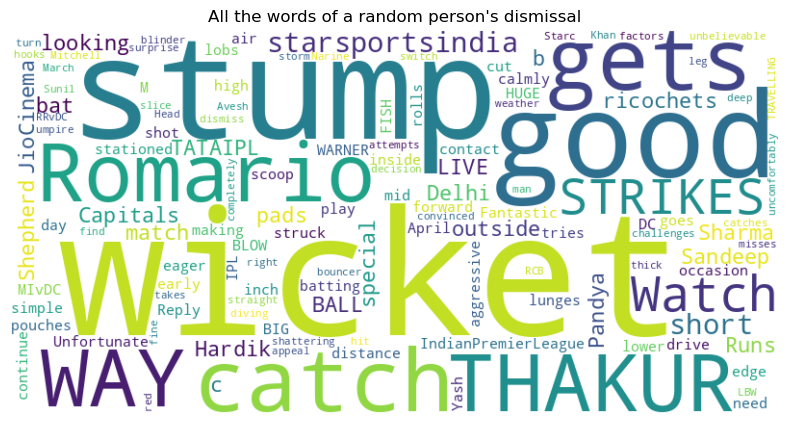

In [13]:
create_word_cloud(random_wicket_frequency,'All the words of a random person\'s dismissal')

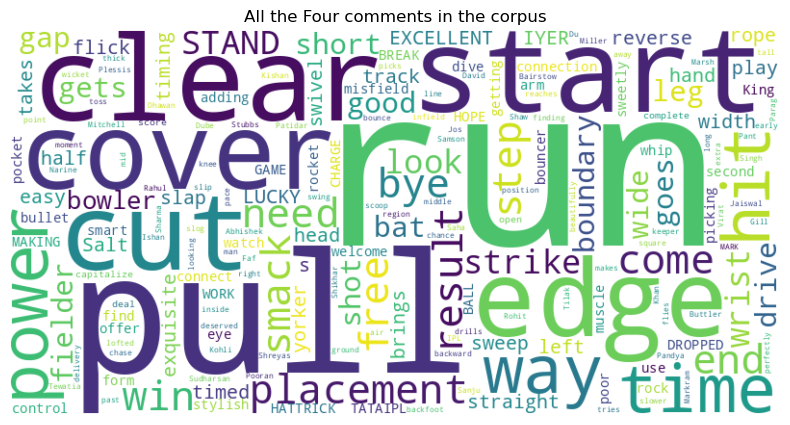

In [14]:
create_word_cloud(four_freq,'All the Four comments in the corpus')

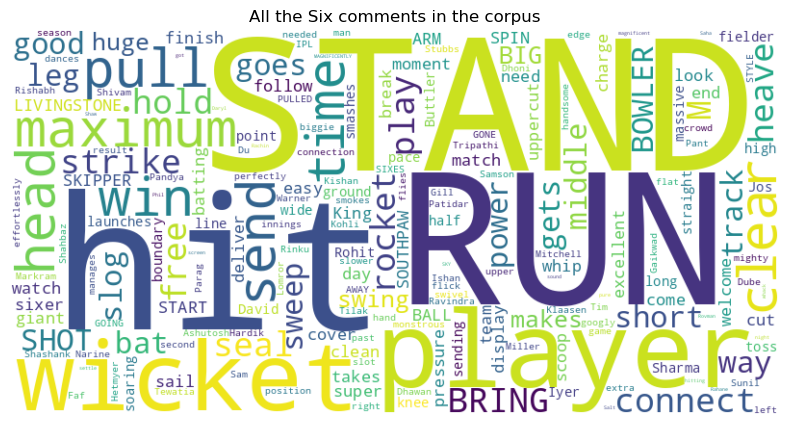

In [15]:
create_word_cloud(six_freq,'All the Six comments in the corpus')

In [16]:
text = ' '.join(df['comment'].to_list()[:6500])

In [17]:

doc = nlp(text)
print(doc.count_by(spacy.attrs.POS))
for key,value in doc.count_by(spacy.attrs.POS).items():
    print(f"We have {value} '{spacy.explain(nlp.vocab[key].text)}' in entire corpus")
    break



{96: 21795, 100: 19820, 84: 21604, 92: 43340, 97: 23651, 85: 23252, 86: 7205, 90: 17330, 94: 999, 89: 2928, 87: 1576, 103: 2174, 93: 2565, 95: 3169, 101: 74, 98: 383, 91: 28, 99: 89}
We have 21795 'proper noun' in entire corpus


In [18]:
all_adjectives = []
all_verbs = []

for token in doc:
    if token.pos == 84:
        all_adjectives.append(token.text)
    elif token.pos == 100:
        all_verbs.append(token.lemma_)


In [19]:
all_persons = []
all_org = []
for ent in doc.ents:
    if ent.label_ == 'PERSON':
        all_persons.append(ent.text)
    elif ent.label_ == 'ORG':
        all_org.append(ent.text)
    
    # break
    # print(ent,ent.label)

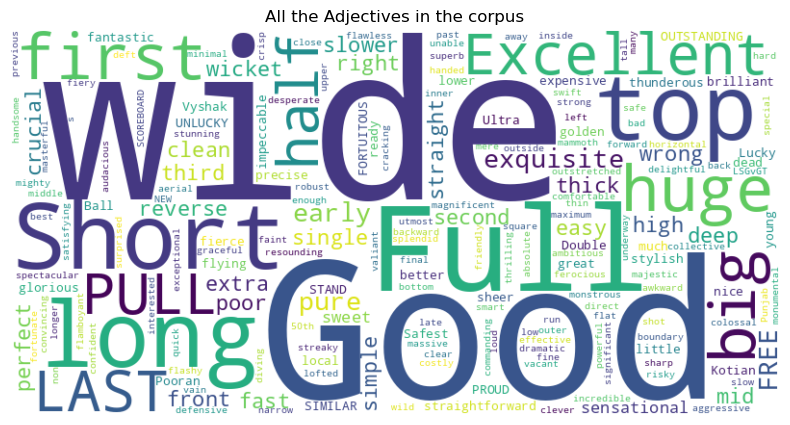

In [20]:
create_word_cloud(sorted(Counter(all_adjectives).items(), key=lambda x:x[1],reverse=True),'All the Adjectives in the corpus')


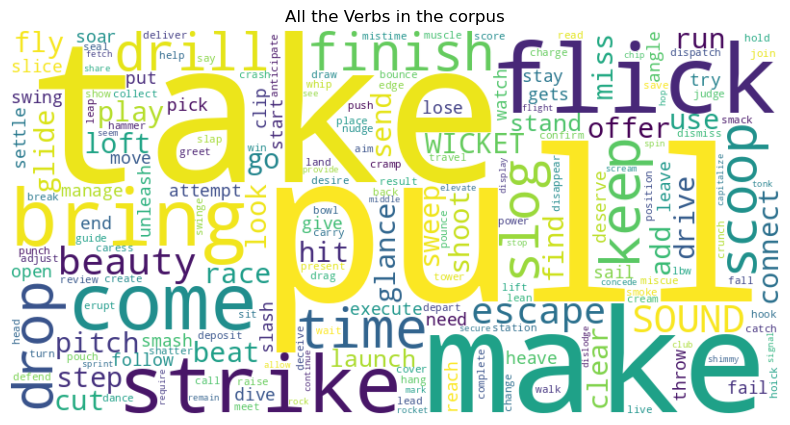

In [21]:

create_word_cloud(sorted(Counter(all_verbs).items(), key=lambda x:x[1],reverse=True),'All the Verbs in the corpus')

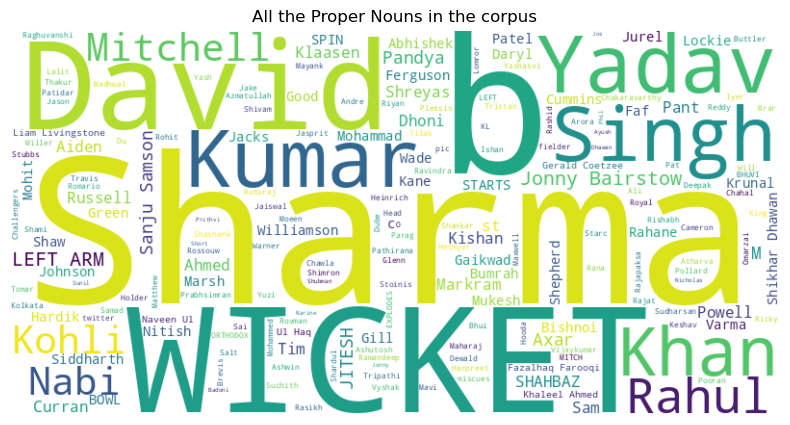

In [22]:

create_word_cloud(sorted(Counter(all_persons).items(), key=lambda x:x[1],reverse=True),'All the Proper Nouns in the corpus')

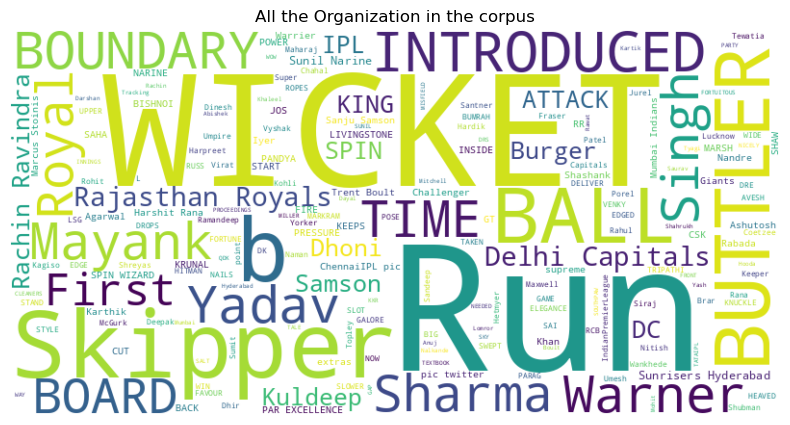

In [23]:

create_word_cloud(sorted(Counter(all_org).items(), key=lambda x:x[1],reverse=True),'All the Organization in the corpus')

In [24]:
updated_ents = []
orgs_to_remove = ['BUTTLER','Singh', 'Virat Kohli','SHARMA','Deepak Hooda','K L Rahul','Patel','Naman Dhir','Harpreet Brar','NEEDED','Kagiso Rabada','SKY','PARTY','Rohit','Ashutosh','Shaw','Rachin Ravindra','Kohli','Sharma','ATTACK','pic twitter','Iyer','Virat','Mayank','Mayank Agarwal','START']
for ent in doc.ents:

    
    if ent.label_ == 'ORG' and ent.text not in orgs_to_remove  :
        if not ent.text.startswith('pic.'):
            updated_ents.append(ent)
doc.ents = updated_ents


all_persons = []
all_org = []


for ent in doc.ents:
    if ent.label_ == 'PERSON':
        all_persons.append(ent.text)
    elif ent.label_ == 'ORG':
        all_org.append(ent.text)

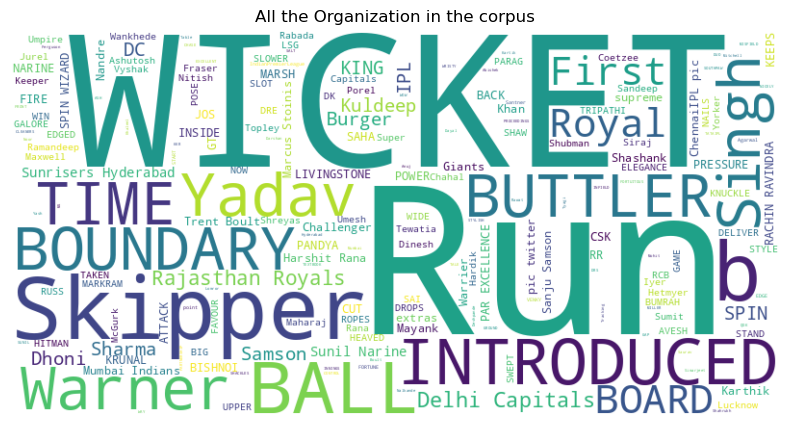

In [25]:

create_word_cloud(sorted(Counter(all_org).items(), key=lambda x:x[1],reverse=True),'All the Organization in the corpus')

In [26]:
doc.ents

(Mumbai Indians,
 TIME,
 Mumbai Indians,
 Mumbai Indians 167 Runs,
 IPL,
 Yorker,
 BALL,
 ON FIRE NOW,
 STYLISH,
 Mumbai Indians,
 HITMAN,
 PROCEEDINGS,
 WICKET Kagiso Rabada,
 BALL,
 WICKET Harpreet Brar,
 TALE,
 MAIDEN IPL,
 SLOWER,
 WICKET Shashank Singh,
 LOOSE,
 Shashank,
 Shashank,
 Hardik,
 INNINGS,
 Shashank,
 Yorker,
 SONG,
 Coetzee,
 Shashank,
 Coetzee,
 Coetzee,
 BUMRAH,
 NAAH,
 Kings,
 Sumit,
 FRONT,
 Tewatia,
 Yorker,
 EDGES,
 Shahrukh Khan,
 Manohar's,
 BALL,
 Yorker,
 SAI SU,
 the Vijay Hazare Player of the Tournament,
 TIMBER,
 TEXTBOOK,
 GAP,
 DC LAND A BIG BLOW,
 SKIPPER,
 WICKET Shubman Gill,
 SLAP,
 WIN,
 Sumit,
 REVERSE,
 Mohit,
 Delhi Capitals,
 Sandeep Warrier,
 Delhi Capitals 65 Runs,
 Abishek Porel,
 Abishek Porel,
 WARRIER,
 Sandeep Warrier b,
 Sandeep Warrier,
 Delhi Capitals,
 SHAWT,
 Saha,
 Saha,
 Fraser-McGurk's,
 Fraser-McGurk,
 Fraser-McGurk,
 Delhi Capitals,
 Mohit,
 Sourav Ganguly,
 RINKU,
 STANDS,
 Yorker,
 FORTUITOUS,
 ON THE BOARD IN STYLE,
 Yorker,

In [27]:
spacy.explain(nlp.vocab[92].text)

'noun'

In [28]:
text = df['comment'][(df['batsmen'] == 'Virat Kohli') & (df['score'] == 'W')].to_list()[0]

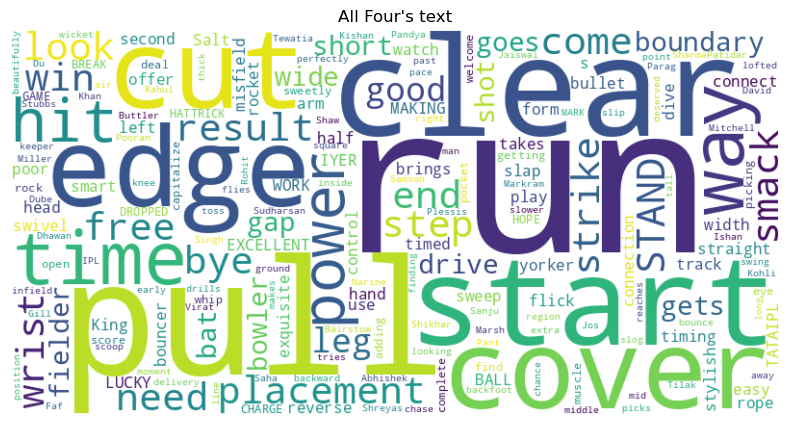

In [29]:
create_word_cloud(four_freq,'All Four\'s text')

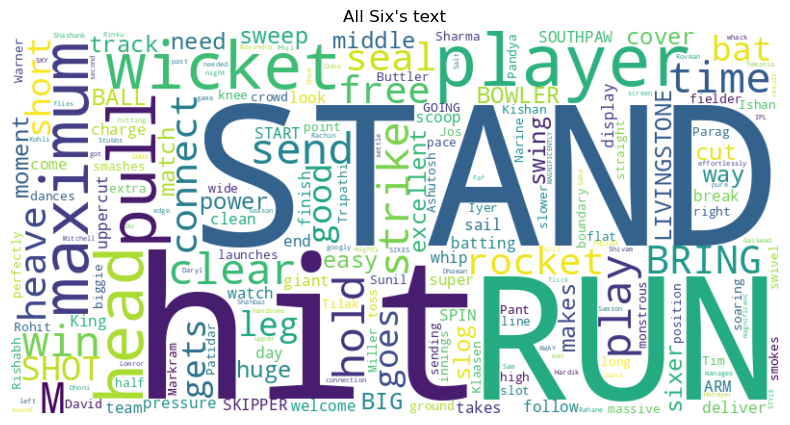

In [30]:
create_word_cloud(six_freq,'All Six\'s text')


In [31]:
from sklearn.model_selection import train_test_split

In [32]:
df['comment'].duplicated().sum()

5

In [33]:
from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize
import numpy as np



tokenized_corpus = [word_tokenize(sentence.lower()) for sentence in df['comment']]

word2vec_model = Word2Vec(sentences=tokenized_corpus, vector_size=100, window=5, min_count=3, workers=4,sample=0.001,negative=5)

sentence_vectors = []

# iterate over each sentence in the corpus
for sentence in df['comment']:
    
    # tokenize the sentence and convert to lowercase
    tokens = word_tokenize(sentence.lower())

    word_vectors = []

    # token = 'each word in the sentence' 
    for token in tokens:
        try:
            # Word Vector for the token mentioned.
            word_vector = word2vec_model.wv[token]
        
            word_vectors.append(word_vector)
        except KeyError:
            # Out of Vocabulary excluded
            pass
        
    # If there are word vectors for the sentence
    if word_vectors:
        # Calculate the average of the word vectors to obtain the sentence vector
        sentence_vector = np.mean(word_vectors, axis=0)
    else:
        # If no word vectors were found for the sentence, use a zero vector
        sentence_vector = np.zeros(word2vec_model.vector_size)

    # Append the sentence vector to the list of sentence vectors
    sentence_vectors.append(sentence_vector)

sentence_vectors = np.array(sentence_vectors)


In [34]:

df['score_converted'] = df['score'].apply(lambda x: 8 if x == 'W' else int(x))
y = df['score_converted']

y_categorical = tf.keras.utils.to_categorical(y)
X = sentence_vectors
print(X.shape,'X.shape')
print(y_categorical.shape,'y_categorical.shape')

(9992, 100) X.shape
(9992, 9) y_categorical.shape


In [35]:
from num2words import num2words

label_mapping = {}
for label, categorical_representation in zip(y, y_categorical):
    if label == 8:
        label = 'Wicket'
    else:
        english_word = num2words(label)
        unit = 'Runs'
        if english_word == 'one' :
            unit = "Run"
        label = f'{english_word.title()} {unit}'
    label_mapping[np.argmax(categorical_representation)] = label 


In [36]:
label_mapping

{8: 'Wicket',
 1: 'One Run',
 4: 'Four Runs',
 6: 'Six Runs',
 0: 'Zero Runs',
 2: 'Two Runs',
 7: 'Seven Runs',
 5: 'Five Runs',
 3: 'Three Runs'}

In [37]:
import tensorflow as tf

# Define the model
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(100,)),
    tf.keras.layers.Flatten(),

    # Tried with different number of layers
    # tf.keras.layers.Dense(256, activation='tanh'),
    # tf.keras.layers.Dense(256, activation='tanh'),

    # tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),

    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(9, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Print model summary
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 100)               0         
_________________________________________________________________
dense (Dense)                (None, 128)               12928     
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_2 (Dense)              (None, 9)                 585       
Total params: 21,769
Trainable params: 21,769
Non-trainable params: 0
_________________________________________________________________


In [38]:

# Step 4: Train-test split
X_train, X_test, y_train, y_test = train_test_split(sentence_vectors,y_categorical,random_state=33,test_size=0.3)

# Train the model
history = model.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test))

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

Epoch 1/100
219/219 [==============================] - 1s 2ms/step - loss: 0.7899 - accuracy: 0.7326 - val_loss: 0.5311 - val_accuracy: 0.8292
Epoch 2/100
219/219 [==============================] - 0s 1ms/step - loss: 0.4446 - accuracy: 0.8476 - val_loss: 0.4058 - val_accuracy: 0.8606
Epoch 3/100
219/219 [==============================] - 0s 1ms/step - loss: 0.3792 - accuracy: 0.8679 - val_loss: 0.3732 - val_accuracy: 0.8666
Epoch 4/100
219/219 [==============================] - 0s 1ms/step - loss: 0.3434 - accuracy: 0.8753 - val_loss: 0.3462 - val_accuracy: 0.8736
Epoch 5/100
219/219 [==============================] - 0s 1ms/step - loss: 0.3245 - accuracy: 0.8845 - val_loss: 0.3291 - val_accuracy: 0.8799
Epoch 6/100
219/219 [==============================] - 0s 1ms/step - loss: 0.3071 - accuracy: 0.8868 - val_loss: 0.3129 - val_accuracy: 0.8866
Epoch 7/100
219/219 [==============================] - 0s 1ms/step - loss: 0.2977 - accuracy: 0.8925 - val_loss: 0.3075 - val_accuracy: 0.8906

In [39]:
with open('model.pkl', 'wb') as f:
    pickle.dump(model, f)

TypeError: cannot pickle 'weakref' object

In [ ]:
def create_vector(list_of_comments):
    
    sentence_vectors = []
    # Iterate over each sentence in the corpus
    for sentence in list_of_comments:
        # Tokenize the sentence and convert to lowercase
        tokens = word_tokenize(sentence.lower())

        
        word_vectors = []
        # Iterate over each word in the sentence
        for token in tokens:
            try:
                # Retrieve the word vector from the Word2Vec model
                word_vector = word2vec_model.wv[token]
                
                # Append the word vector to the list of word vectors
                word_vectors.append(word_vector)
            except KeyError:
                # Handle out-of-vocabulary words
        
                pass
        # If there are word vectors for the sentence
        if word_vectors:
            # word found -> mean of the vector
            sentence_vector = np.mean(word_vectors, axis=0)
            print(sentence_vector)
        else:
            # no word -> 0's
            sentence_vector = np.zeros(word2vec_model.vector_size)
        sentence_vectors.append(sentence_vector)
    
    # list -> np array
    sentence_vectors = np.array(sentence_vectors)
    return sentence_vectors

In [ ]:
def predict_score(text):
    # Converting text to preprocessing
    text_vectorization = create_vector([text])
    
    # Predicting the given text
    predicted_value = model.predict(text_vectorization)
    print(label_mapping[predicted_value.argmax()])


In [ ]:
predict_score(" good length ball, pitching on leg stump, Rahul Tewatia plays it smartly, waiting for the ball and expertly glancing it, using both the pace and the angle from the bowler. The ball finds its way swiftly between the wicket-keeper and short fine leg, sprinting to the boundary. This final stroke clinches a narrow 3-wicket victory for GT in a nail-biting finish. Overwhelmed with emotion, Tewatia celebrates in a style reminiscent of Mohit Sharma's iconic celebration, marking a dramatic end to the contest. PBKS, on the other hand, endure yet another heartbreak in Mullanpur, adding to their string of close encounters that didn't go their way.")

NameError: name 'word_tokenize' is not defined

In [ ]:
from transformers import DistilBertForTokenClassification, DistilBertTokenizer
import torch
from PIL import Image

# Step 1: Preprocess the image
image_path = "cropped_image.jpg"
image = Image.open(image_path)

# Step 2: Load the model and tokenizer
model_name = "distilbert-base-uncased"
tokenizer = DistilBertTokenizer.from_pretrained(model_name)
model = DistilBertForTokenClassification.from_pretrained(model_name)

# Step 3: Perform inference
inputs = tokenizer(image, return_tensors="pt", padding=True, truncation=True)
with torch.no_grad():
    outputs = model(**inputs)

# Step 4: Postprocess the output
# You may need to extract and decode the text from the model's output based on the specific token classification task

# Step 5: Output the extracted text or further process it as needed


Some weights of DistilBertForTokenClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ValueError: text input must be of type `str` (single example), `List[str]` (batch or single pretokenized example) or `List[List[str]]` (batch of pretokenized examples).

In [ ]:
# predict_0 = create_vector(['Good length ball, pitching outside off stump, Mukesh Kumar plays a defensive shot on back foot, no run'])
# predict_8 = create_vector([' yorker ball, pitching on middle stump, Anrich Nortje finds himself outmaneuvred by a blistering delivery. Positioned leg side of the ball, he scrambles unsuccessfully to bring his bat down in time. Missing the drive at the toe end, the ball zips under his bat, striking with precision to disrupt the base of the stumps.'])
# predict_1 = create_vector(['Full length ball, pitching on off stump, Axar Patel uncomfortably plays an aggressive lofted on drive on the front foot for a single'])
# predict_2 = create_vector(['Yorker ball, pitching on off stump, Rishabh Pant plays an aggressive front foot flick for 2 runs'])
# predict_wd = create_vector(['Short length ball, pitching outside off stump, Rishabh Pant offers no shot, 1 wide(s) gets added to the extras'])
# predict_value_0 = model.predict(predict_0)
# predict_value_8 = model.predict(predict_8)
# predict_value_1 = model.predict(predict_1)
# predict_value_2 = model.predict(predict_2)
# predict_value_wd = model.predict(predict_wd)





'One Run'

In [ ]:
import numpy as np

In [ ]:
from nltk.tokenize import word_tokenize


In [ ]:
from gensim.models import Word2Vec
from nltk.tokenize import sent_tokenize

# Your input string
input_text1 = "Your input text goes here." 
input_text2 = "It may contain multiple sentences."

# Tokenize the text into sentences
# sentences = sent_tokenize(input_text.split())

# print(sentences)
# Train the Word2Vec model
print([input_text1.split(),input_text2.split()])
model = Word2Vec([input_text1.split(),input_text2.split()], vector_size=10, window=5, min_count=1, workers=4)
print(model.wv.most_similar('input'))
# Now you can use the model for various tasks
model.wv.index_to_key

[['Your', 'input', 'text', 'goes', 'here.'], ['It', 'may', 'contain', 'multiple', 'sentences.']]
[('sentences.', 0.3792896866798401), ('here.', 0.27556225657463074), ('may', 0.20713214576244354), ('multiple', 0.035253219306468964), ('Your', -0.021763434633612633), ('contain', -0.11288785189390182), ('text', -0.27751079201698303), ('It', -0.3017638027667999), ('goes', -0.3901774287223816)]


['sentences.',
 'multiple',
 'contain',
 'may',
 'It',
 'here.',
 'goes',
 'text',
 'input',
 'Your']

In [ ]:

all_comments = []
# all_comments = np.array([])
comments = df['comment']

for comment in comments:
    all_comments.append(comment.split())
    

In [ ]:
dir(model.wv)
print(model.wv.index_to_key)

['sentences.', 'multiple', 'contain', 'may', 'It', 'here.', 'goes', 'text', 'input', 'Your']


In [ ]:


model = Word2Vec(all_comments, vector_size=10, window=5, min_count=1, workers=4)
print(model.wv.most_similar(['full','toss']))

# model.wv.index_to_key
model.wv.most_similar(all_comments[0])


[('Abdul', 0.9858542084693909), ('Yorker', 0.9783129692077637), ('good', 0.9706043601036072), ('Shai', 0.9694623351097107), ('MS', 0.9601619243621826), ('Agarwal', 0.9600962400436401), ('Mahipal', 0.9550661444664001), ('POWERPLAY!', 0.9516740441322327), ('Short', 0.9513789415359497), ('Full', 0.9498714208602905)]


[('handing', 0.9742090702056885),
 ('attempts', 0.9727221727371216),
 ('easy', 0.9690255522727966),
 ('width', 0.9688984155654907),
 ('back-foot', 0.9683092832565308),
 ('dances', 0.9680731296539307),
 ('early', 0.9649746417999268),
 ('attempting', 0.9647336602210999),
 ('capitalizes', 0.9638200402259827),
 ('walks', 0.9632455110549927)]

In [ ]:
def text_to_vector(text):
    words = text.split()
    vectors = [model.wv[word] for word in words if word in model.wv]
    if vectors:
        return np.mean(vectors, axis=0)
    else:
        return np.zeros(model.vector_size)

In [ ]:
model.wv['full'].shape

(10,)

In [ ]:
import tensorflow as tf

# Define the model
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(10,)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(9, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Print model summary
model.summary()


Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_5 (Flatten)          (None, 10)                0         
_________________________________________________________________
dense_15 (Dense)             (None, 128)               1408      
_________________________________________________________________
dense_16 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_17 (Dense)             (None, 9)                 585       
Total params: 10,249
Trainable params: 10,249
Non-trainable params: 0
_________________________________________________________________


In [ ]:
from spacy import displacy #visualization tool

In [ ]:
for each in list(doc.sents):
    print(each)
    
    displacy.render(each,jupyter=True)
    displacy.render(each,style='ent',jupyter=True)
    # break

 Sandeep Warrier bowling to Prithvi Shaw Sandeep Warrier bowling to Prithvi Shaw
THE GT DEBUTANT IS GIVEN THE NEW BALL!


Good length ball, pitching outside off stump, Prithvi Shaw glides it for a single Sandeep Warrier bowling to Prithvi Shaw
THE GT DEBUTANT IS GIVEN THE NEW BALL!


Good length ball, pitching outside off stump, Prithvi Shaw glides it for a single 0.1
1
Sandeep Warrier bowling to Prithvi Shaw
THE GT DEBUTANT IS GIVEN THE NEW BALL!


Good length ball, pitching outside off stump, Prithvi Shaw glides it for a single  Sandeep Warrier bowling to Jake Fraser-McGurk Sandeep Warrier bowling to Jake Fraser-McGurk
WHAT A WAY TO KICKSTART HIS INNINGS!  


Good length ball, pitching outside off stump, Jake Fraser-McGurk lofts the ball powerfully straight down the ground for a massive six!


In the DC dugout, Sourav Ganguly can't help but shake his head, offering a smug smile as he watches the spectacle unfold.


FIRST BALL BUT JFM MAKES IT LOOK LIKE HE'S BEEN BATTING ALL ALONG!


0.2
6
Sandeep Warrier bowling to Jake Fraser-McGurk
WHAT


A WAY TO KICKSTART HIS INNINGS!  


c:\Users\Poorn\anaconda3\envs\gpu\lib\site-packages\spacy\displacy\__init__.py:213: UserWarning: [W006] No entities to visualize found in Doc object. If this is surprising to you, make sure the Doc was processed using a model that supports named entity recognition, and check the `doc.ents` property manually if necessary.
  warnings.warn(Warnings.W006)


Good length ball, pitching outside off stump, Jake Fraser-McGurk lofts the ball powerfully straight down the ground for a massive six!


In the DC dugout, Sourav Ganguly can't help but shake his head, offering a smug smile as he watches the spectacle unfold.


FIRST BALL BUT JFM MAKES IT LOOK LIKE HE'S BEEN BATTING ALL ALONG!  


Sandeep Warrier bowling to Jake Fraser-McGurk Sandeep Warrier bowling to Jake Fraser-McGurk
Full length ball, pitching on off stump, Jake Fraser-McGurk uncomfortably plays an aggressive off drive on the front foot, no run 0.3
0
Sandeep Warrier bowling to Jake Fraser-McGurk
Full length ball, pitching on off stump, Jake Fraser-McGurk uncomfortably plays an aggressive off drive on the front foot, no run  Sandeep Warrier bowling to Jake Fraser-McGurk Sandeep Warrier bowling to Jake Fraser-McGurk
THIS LAD IS SPECIAL!  


Full length ball, pitching outside off stump, Jake Fraser-McGurk smacks the ball fiercely, straight down the ground again!


0.4
4
Sandeep Warrier bowling to Jake Fraser-McGurk
THIS LAD IS SPECIAL!  


Full length ball, pitching outside off stump, Jake Fraser-McGurk smacks the ball fiercely, straight down the ground again!  


Sandeep Warrier bowling to Jake Fraser-McGurk Sandeep Warrier bowling to Jake Fraser-McGurk
Good length ball, pitching on off stump, Jake Fraser-McGurk uncomfortably leg glances it, 1 leg bye(s) gets added to the extras 0.5
1 LB
Sandeep Warrier bowling to Jake Fraser-McGurk
Good length ball, pitching on off stump, Jake Fraser-McGurk uncomfortably leg glances it, 1 leg bye(s) gets added to the extras  Sandeep Warrier bowling to Prithvi Shaw Sandeep Warrier bowling to Prithvi Shaw
Short of good length ball, pitching outside off stump, Prithvi Shaw flicks the ball towards deep fine leg, managing to scurry for a double.


The Titans, suspecting an lbw, decide to challenge the on-field decision.


The review shows that the ball indeed struck the pads, resulting in leg-byes, and ball-tracking reveals it was only clipping the outside of the leg stump, confirming the not-out decision.


However, the Titans retain their review due to the umpire's call on impact.


2 leg bye(s) gets added to the extras.


0.6
2 LB
Sandeep Warrier bowling to Prithvi Shaw
Short of good length ball, pitching outside off stump, Prithvi Shaw flicks the ball towards deep fine leg, managing to scurry for a double.


The Titans, suspecting an lbw, decide to challenge the on-field decision.


The review shows that the ball indeed struck the pads, resulting in leg-byes, and ball-tracking reveals it was only clipping the outside of the leg stump, confirming the not-out decision.


However, the Titans retain their review due to the umpire's call on impact.


2 leg bye(s) gets added to the extras.


14/0 2 LB 1 LB 4 0 6 1  Spencer Johnson bowling to Jake Fraser-McGurk Spencer Johnson bowling to Jake Fraser-McGurk
Good length ball, pitching outside leg stump, Jake Fraser-McGurk leg glances it, 1 wide(s) gets added to the extras 1.1
1 WD
Spencer Johnson bowling to Jake Fraser-McGurk
Good length ball, pitching outside leg stump, Jake Fraser-McGurk leg glances it, 1 wide(s) gets added to the extras  Spencer Johnson bowling to Jake Fraser-McGurk Spencer Johnson bowling to Jake Fraser-McGurk
GOTTA LOVE THAT BAT SWING!  


short of good length ball, pitching outside off stump, Jake Fraser-McGurk makes ample room to free his arms.


With a flourish, he slaps the ball high over the cover, executing a sublime aerial drive that sails over the off-side field.


1.1
6
Spencer Johnson bowling to Jake Fraser-McGurk
GOTTA LOVE THAT BAT SWING!  


short of good length ball, pitching outside off stump, Jake Fraser-McGurk makes ample room to free his arms.


With a flourish, he slaps the ball high over the cover, executing a sublime aerial drive that sails over the off-side field.  


Spencer Johnson bowling to Jake Fraser-McGurk Spencer Johnson bowling to Jake Fraser-McGurk
Short length ball, pitching outside leg stump, Jake Fraser-McGurk uncomfortably plays an aggressive pull shot on the front foot, no run 1.2
0
Spencer Johnson bowling to Jake Fraser-McGurk
Short length ball, pitching outside leg stump, Jake Fraser-McGurk uncomfortably plays an aggressive pull shot on the front foot, no run  Spencer Johnson bowling to Jake Fraser-McGurk Spencer Johnson bowling to Jake Fraser-McGurk
Short length ball, pitching outside leg stump, Jake Fraser-McGurk plays an aggressive pull shot on the back foot and is beaten 1.3
0
Spencer Johnson bowling to Jake Fraser-McGurk
Short length ball, pitching outside leg stump, Jake Fraser-McGurk plays an aggressive pull shot on the back foot and is beaten  Spencer Johnson bowling to Jake Fraser-McGurk Spencer Johnson bowling to Jake Fraser-McGurk
Good length ball, pitching outside leg stump, Jake Fraser-McGurk plays the scoop and is beat

Short length ball, pitching on leg stump, Jake Fraser-McGurk backs away to launch a powerful off-side slap, he doesn't quite connect perfectly.


The ball, toe-ended, unexpectedly squirts past a surprised Mohit at short third man, racing away for a boundary.


1.5
4
Spencer Johnson bowling to Jake Fraser-McGurk
 CRUISING TOWARDS THEIR TARGET!


Short length ball, pitching on leg stump, Jake Fraser-McGurk backs away to launch a powerful off-side slap, he doesn't quite connect perfectly.


The ball, toe-ended, unexpectedly squirts past a surprised Mohit at short third man, racing away for a boundary.  


Spencer Johnson bowling to Jake Fraser-McGurk Spencer Johnson bowling to Jake Fraser-McGurk
CUNNING DISMISSAL!


Johnson masterfully capitalizes on Fraser-McGurk's positioning!


Good length ball, pitching outside leg stump, swinging further down the leg side, he finds the batsman moving towards the leg, effectively trapping himself.


Fraser-McGurk attempts a checked flick but ends up playing it with hard hands straight to midwicket, where the fielder makes no mistake.


A strategic delivery results in a crucial wicket as Fraser-McGurk walks back, outsmarted and dismissed.




WICKET Jake Fraser-McGurk c Abhinav Manohar b Spencer Johnson (Delhi Capitals 25 Runs for 1 wicket) 1.6
W
Spencer Johnson bowling to Jake Fraser-McGurk
CUNNING DISMISSAL!


Johnson masterfully capitalizes on Fraser-McGurk's positioning!


Good length ball, pitching outside leg stump, swinging further down the leg side, he finds the batsman moving towards the leg, effectively trapping himself.


Fraser-McGurk attempts a checked flick but ends up playing it with hard hands straight to midwicket, where the fielder makes no mistake.


A strategic delivery results in a crucial wicket as Fraser-McGurk walks back, outsmarted and dismissed.




WICKET Jake Fraser-McGurk c Abhinav Manohar b Spencer Johnson (Delhi Capitals 25 Runs for 1 wicket)


25/1


W 4 0 0 0 6 1 WD  Sandeep Warrier bowling to Prithvi Shaw Sandeep Warrier bowling to Prithvi Shaw
Good length ball, pitching outside off stump, Prithvi Shaw uncomfortably leg glances it, no run.


Gill, caught up in the heat of the moment and disregarding Saha's cautious advice, opts for an LBW review.


Saha, left with no choice, can only offer a wry smile as the decision unfolds.


The delivery, a sharp nipbacker heading down leg, tempts Prithvi Shaw into an ambitious flick across the line.


He misses, and the ball is clearly heading down the leg side, making it an easy call for the umpires.


This results in a squandered review for Gill's team, reflecting a moment of overzealous decision-making.


2.1
0
Sandeep Warrier bowling to Prithvi Shaw
Good length ball, pitching outside off stump, Prithvi Shaw uncomfortably leg glances it, no run.


Gill, caught up in the heat of the moment and disregarding Saha's cautious advice, opts for an LBW review.


Saha, left with no choice, can only offer a wry smile as the decision unfolds.


The delivery, a sharp nipbacker heading down leg, tempts Prithvi Shaw into an ambitious flick across the line.


He misses, and the ball is clearly heading down the leg side, making it an easy call for the umpires.


This results in a squandered review for Gill's team, reflecting a moment of overzealous decision-making.  


Sandeep Warrier bowling to Prithvi Shaw Sandeep Warrier bowling to Prithvi Shaw



That's not a shot!


That's a SHAWT!


short of good length ball, pitching outside off stump, effortlessly reading the delivery's length early, Prithvi Shaw executes a signature whip over mid-wicket.


2.2
4
Sandeep Warrier bowling to Prithvi Shaw
That's not a shot!


That's a SHAWT!


short of good length ball, pitching outside off stump, effortlessly reading the delivery's length early, Prithvi Shaw executes a signature whip over mid-wicket.  


Sandeep Warrier bowling to Prithvi Shaw Sandeep Warrier bowling to Prithvi Shaw
Full length ball, pitching on off stump, Prithvi Shaw drives it straight aggressively using the front foot for 2 runs 2.3
2
Sandeep Warrier bowling to Prithvi Shaw
Full length ball, pitching on off stump, Prithvi Shaw drives it straight aggressively using the front foot for 2 runs  Sandeep Warrier bowling to Prithvi Shaw Sandeep Warrier bowling to Prithvi Shaw
WARRIER THE WARRIOR!  pitching outside off stump, he delivers a terrific short ball, bending his back to generate extra bounce and catching Shaw off-guard.


Rather than ducking, Shaw opts to protect his face with his bat, leading to a fateful decision as the ball lobs up to short third man for an easy catch.


Shaw, clearly surprised by the lift and pace of the delivery, departs, giving Warrier a well-earned wicket through clever and aggressive bowling.




WICKET Prithvi Shaw c


Sandeep Warrier b Sandeep Warrier (Delhi Capitals 31 Runs for 2 wickets) 2.4
W
Sandeep Warrier bowling to Prithvi Shaw
WARRIER THE WARRIOR!  


pitching outside off stump, he delivers a terrific short ball, bending his back to generate extra bounce and catching Shaw off-guard.


Rather than ducking, Shaw opts to protect his face with his bat, leading to a fateful decision as the ball lobs up to short third man for an easy catch.


Shaw, clearly surprised by the lift and pace of the delivery, departs, giving Warrier a well-earned wicket through clever and aggressive bowling.




WICKET Prithvi Shaw c


Sandeep Warrier b Sandeep Warrier (Delhi Capitals 31 Runs for 2 wickets)  


Sandeep Warrier bowling to Shai Hope Sandeep Warrier bowling to Shai Hope
Good length ball, pitching outside off stump, Shai Hope plays an aggressive cover drive on the front foot and is beaten 2.5
0
Sandeep Warrier bowling to Shai Hope
Good length ball, pitching outside off stump, Shai Hope plays an aggressive cover drive on the front foot and is beaten  Sandeep Warrier bowling to Shai Hope Sandeep Warrier bowling to Shai Hope
Short of good length ball, pitching outside off stump, Shai Hope plays a defensive shot on back foot, no run 2.6
0
Sandeep Warrier bowling to Shai Hope
Short of good length ball, pitching outside off stump, Shai Hope plays a defensive shot on back foot, no run 31/2 0 0


W 2 4 0  Spencer Johnson bowling to Abishek Porel Spencer Johnson bowling to Abishek Porel
Short of good length ball, pitching outside off stump, Abishek Porel glides it for a single Spencer Johnson bowling to Abishek Porel
Short of good length ball, pitching outside off stump, Abishek Porel glides it for a single 3.1
1
Spencer Johnson bowling to Abishek Porel
Short of good length ball, pitching outside off stump, Abishek Porel glides it for a single  Spencer Johnson bowling to Shai Hope Spencer Johnson bowling to Shai Hope
Good length ball, pitching outside leg stump, Shai Hope leg glances it for a single 3.2
1
Spencer Johnson bowling to Shai Hope
Good length ball, pitching outside leg stump, Shai Hope leg glances it for a single  Spencer Johnson bowling to Abishek Porel Spencer Johnson bowling to Abishek Porel
Short of good length ball, pitching outside off stump, Abishek Porel uncomfortably plays an aggressive pull shot on the back foot, no run 3.3
0
Spencer Johnson bowling to Abish

good length ball, pitching outside off stump, anchored firmly in his crease, Abishek Porel unleashes a sharp, punchy drive off the back foot.


The shot is executed with precision, slicing through the narrow gap between point and cover point, showcasing his exceptional timing and placement.


3.5
4
Spencer Johnson bowling to Abishek Porel
PRECISE DRIVE!  


good length ball, pitching outside off stump, anchored firmly in his crease, Abishek Porel unleashes a sharp, punchy drive off the back foot.


The shot is executed with precision, slicing through the narrow gap between point and cover point, showcasing his exceptional timing and placement.  


Spencer Johnson bowling to Abishek Porel Spencer Johnson bowling to Abishek Porel
EFFORTLESS PULL!  


short length ball, pitching outside off stump, Abishek Porel expertly swivels and connects with a powerful pull shot.


He finds the gap, sending the ball racing towards the unmanned deep square leg boundary for a smooth four.


This shot showcases his quick reflexes and a keen eye for exploiting field placements.


3.6
4
Spencer Johnson bowling to Abishek Porel
EFFORTLESS PULL!  


short length ball, pitching outside off stump, Abishek Porel expertly swivels and connects with a powerful pull shot.


He finds the gap, sending the ball racing towards the unmanned deep square leg boundary for a smooth four.


This shot showcases his quick reflexes and a keen eye for exploiting field placements.    


42/2 4 4 1 WD 0 0 1 1  Sandeep Warrier bowling to Shai Hope Sandeep Warrier bowling to Shai Hope
HOPE JOINS THE PARTY!


Good length ball, pitching on leg stump, aimed at his pads, Shai Hope skillfully closes the face of his bat, executing a stylish flick.


He lifts it effortlessly over the midwicket fielder, sending the ball soaring into the boundary for a graceful four runs!


4.1
4
Sandeep Warrier bowling to Shai Hope
HOPE JOINS THE PARTY!


Good length ball, pitching on leg stump, aimed at his pads, Shai Hope skillfully closes the face of his bat, executing a stylish flick.


He lifts it effortlessly over the midwicket fielder, sending the ball soaring into the boundary for a graceful four runs!  


Sandeep Warrier bowling to Shai Hope Sandeep Warrier bowling to Shai Hope
50 UP IN NO TIME!  


short length ball, pitching on off stump, Shai Hope takes a bold charge down the pitch, then unloads a powerful flat-bat stroke, launching the ball high and far over long on for a commanding six! 4.2
6
Sandeep Warrier bowling to Shai Hope
50 UP IN NO TIME!  


short length ball, pitching on off stump, Shai Hope takes a bold charge down the pitch, then unloads a powerful flat-bat stroke, launching the ball high and far over long on for a commanding six!  


Sandeep Warrier bowling to Shai Hope Sandeep Warrier bowling to Shai Hope
 HAVE HOPE.  


ARE HOPELESS!


good length ball, pitching outside off stump, Shai Hope expertly clips the ball off his pads, deliberately lofting it into the air.


With precise timing and placement, he sends it sailing to the deep square leg boundary for four, demonstrating both his skill and tactical acumen in exploiting the field setup.
  4.3
6
Sandeep Warrier bowling to Shai Hope
 HAVE HOPE.  


ARE HOPELESS!


good length ball, pitching outside off stump, Shai Hope expertly clips the ball off his pads, deliberately lofting it into the air.


With precise timing and placement, he sends it sailing to the deep square leg boundary for four, demonstrating both his skill and tactical acumen in exploiting the field setup.
   


Sandeep Warrier bowling to Shai Hope Sandeep Warrier bowling to Shai Hope
Full length ball, pitching outside off stump, Shai Hope plays an aggressive off drive on the front foot for a single 4.4
1
Sandeep Warrier bowling to Shai Hope
Full length ball, pitching outside off stump, Shai Hope plays an aggressive off drive on the front foot for a single  Sandeep Warrier bowling to Abishek Porel Sandeep Warrier bowling to Abishek Porel
ONLY 25 NEEDED NOW!  


short length ball, pitching outside leg stump, Abishek Porel exhibits his flair and power as he raises his leg while executing a stylish swivel-pull.


With impeccable timing, he connects perfectly and sends the ball soaring deep into the stands for a spectacular six! 4.5
6
Sandeep Warrier bowling to Abishek Porel
ONLY 25 NEEDED NOW!  


short length ball, pitching outside leg stump, Abishek Porel exhibits his flair and power as he raises his leg while executing a stylish swivel-pull.


With impeccable timing, he connects perfectly and sends the ball soaring deep into the stands for a spectacular six!  


Sandeep Warrier bowling to Abishek Porel Sandeep Warrier bowling to Abishek Porel
 FRUSTRATION AT THE CREASE!  


full length ball, pitching on off stump, Abishek Porel attempts an ambitious flick, aiming too square and ultimately missing the ball.


His frustration is palpable as he mockingly swipes his bat towards the stumps in disappointment.


It was not the right delivery for such a square shot, and his reaction highlights his regret!




WICKET Abishek Porel b


Sandeep Warrier (Delhi Capitals 65 Runs for 3 wickets) 4.6
W
Sandeep Warrier bowling to Abishek Porel
 FRUSTRATION AT THE CREASE!  


full length ball, pitching on off stump, Abishek Porel attempts an ambitious flick, aiming too square and ultimately missing the ball.


His frustration is palpable as he mockingly swipes his bat towards the stumps in disappointment.


It was not the right delivery for such a square shot, and his reaction highlights his regret!




WICKET Abishek Porel b


Sandeep Warrier (Delhi Capitals 65 Runs for 3 wickets)


65/3 W 6 1 6 6 4  Rashid Khan bowling to Shai Hope Rashid Khan bowling to Shai Hope
Good length ball, pitching on leg stump, Shai Hope leg glances it for a single 5.1
1
Rashid Khan bowling to Shai Hope
Good length ball, pitching on leg stump, Shai Hope leg glances it for a single  Rashid Khan bowling to Rishabh Pant Rashid Khan bowling to Rishabh Pant
Good length ball, pitching on off stump, Rishabh Pant plays a defensive back foot push for a single 5.2
1
Rashid Khan bowling to Rishabh Pant
Good length ball, pitching on off stump, Rishabh Pant plays a defensive back foot push for a single  Rashid Khan bowling to Shai Hope Rashid Khan bowling to Shai Hope
Good length ball, pitching on off stump, Shai Hope plays a defensive shot on back foot, no run 5.3
0
Rashid Khan bowling to Shai Hope
Good length ball, pitching on off stump, Shai Hope plays a defensive shot on back foot, no run  Rashid Khan bowling to Shai Hope Rashid Khan bowling to Shai Hope
REVERSE SWEEP GONE AWRY!  


full length ball, pitching outside off stump, Shai Hope, attempting a bold reverse sweep, fails to achieve the desired elevation.


Instead of clearing the infield, he inadvertently guides the ball straight to Mohit stationed at the conventional short third position.




WICKET Shai Hope c


Mohit Sharma b Rashid Khan (Delhi Capitals 67 Runs for 4 wickets) 5.4
W
Rashid Khan bowling to Shai Hope
REVERSE SWEEP GONE AWRY!  


full length ball, pitching outside off stump, Shai Hope, attempting a bold reverse sweep, fails to achieve the desired elevation.


Instead of clearing the infield, he inadvertently guides the ball straight to Mohit stationed at the conventional short third position.




WICKET Shai Hope c


Mohit Sharma b Rashid Khan (Delhi Capitals 67 Runs for 4 wickets)  Rashid Khan bowling to Sumit Kumar Rashid Khan bowling to Sumit Kumar
Good length ball, pitching outside off stump, Sumit Kumar cuts it late, no run 5.5
0
Rashid Khan bowling to Sumit Kumar
Good length ball, pitching outside off stump, Sumit Kumar cuts it late, no run  Rashid Khan bowling to Sumit Kumar Rashid Khan bowling to Sumit Kumar
Good length ball, pitching outside off stump, Sumit Kumar plays a forward defensive shot and is beaten 5.6
0
Rashid Khan bowling to Sumit Kumar
Good length ball, pitching outside off stump, Sumit Kumar plays a forward defensive shot and is beaten A VERY EVENTFUL POWERPLAY TO SAY THE LEAST!  


A VERY EVENTFUL POWERPLAY TO SAY THE LEAST!


A VERY EVENTFUL POWERPLAY TO SAY THE LEAST!


67/4 0 0


W 0 1 1  Noor Ahmad bowling to Rishabh Pant Noor Ahmad bowling to Rishabh Pant
Good length ball, pitching outside off stump, Rishabh Pant uncomfortably plays a sweep shot, no run 6.1
0
Noor Ahmad bowling to Rishabh Pant
Good length ball, pitching outside off stump, Rishabh Pant uncomfortably plays a sweep shot, no run  Noor Ahmad bowling to Rishabh Pant Noor Ahmad bowling to Rishabh Pant
FIRST  FOR SKIPPER!


full length ball, pitching wide outside off stump, Rishabh Pant, stretching to his limits and nearly losing his form, still manages to powerfully slap the ball over the off side.


6.2
4
Noor Ahmad bowling to Rishabh Pant
FIRST  FOR SKIPPER!


full length ball, pitching wide outside off stump, Rishabh Pant, stretching to his limits and nearly losing his form, still manages to powerfully slap the ball over the off side.  


Noor Ahmad bowling to Rishabh Pant Noor Ahmad bowling to Rishabh Pant
Good length ball, pitching outside off stump, Rishabh Pant uncomfortably steps down and plays a defensive shot, no run 6.3
0
Noor Ahmad bowling to Rishabh Pant
Good length ball, pitching outside off stump, Rishabh Pant uncomfortably steps down and plays a defensive shot, no run  Noor Ahmad bowling to Rishabh Pant Noor Ahmad bowling to Rishabh Pant
Good length ball, pitching outside off stump, Rishabh Pant plays a sweep shot for a single 6.4
1
Noor Ahmad bowling to Rishabh Pant
Good length ball, pitching outside off stump, Rishabh Pant plays a sweep shot for a single  Noor Ahmad bowling to Sumit Kumar Noor Ahmad bowling to Sumit Kumar
Good length ball, pitching outside leg stump, Sumit Kumar uncomfortably leg glances it, 1 leg bye(s) gets added to the extras 6.5
1 LB
Noor Ahmad bowling to Sumit Kumar
Good length ball, pitching outside leg stump, Sumit Kumar uncomfortably leg glances it, 1 leg bye(s) gets added to the 

full length ball, pitching outside off stump, Rishabh Pant dancing down the track with intent, the batter skillfully converts a full delivery on off stump into a perfect slot ball.


With a powerful muscle-flexing loft, he rides the turn of the googly, sending it sailing over the long-off fielder for a majestic six.


Rashid Khan bowling to Rishabh Pant
THE REQUIREMENT IS IN SINGLE DIGIT NOW!  


full length ball, pitching outside off stump, Rishabh Pant dancing down the track with intent, the batter skillfully converts a full delivery on off stump into a perfect slot ball.


With a powerful muscle-flexing loft, he rides the turn of the googly, sending it sailing over the long-off fielder for a majestic six.


7.3
6
Rashid Khan bowling to Rishabh Pant
THE REQUIREMENT IS IN SINGLE DIGIT NOW!  


full length ball, pitching outside off stump, Rishabh Pant dancing down the track with intent, the batter skillfully converts a full delivery on off stump into a perfect slot ball.


With a powerful muscle-flexing loft, he rides the turn of the googly, sending it sailing over the long-off fielder for a majestic six.  


Rashid Khan bowling to Rishabh Pant Rashid Khan bowling to Rishabh Pant
Full length ball, pitching outside off stump, Rishabh Pant uncomfortably plays a sweep shot for 2 runs 7.4
2
Rashid Khan bowling to Rishabh Pant
Full length ball, pitching outside off stump, Rishabh Pant uncomfortably plays a sweep shot for 2 runs  Rashid Khan bowling to Rishabh Pant Rashid Khan bowling to Rishabh Pant
Full length ball, pitching on off stump, Rishabh Pant uncomfortably plays an aggressive lofted on drive on the front foot, no run 7.5
0
Rashid Khan bowling to Rishabh Pant
Full length ball, pitching on off stump, Rishabh Pant uncomfortably plays an aggressive lofted on drive on the front foot, no run  Rashid Khan bowling to Rishabh Pant Rashid Khan bowling to Rishabh Pant
Good length ball, pitching outside off stump, Rishabh Pant cuts it late, no run 7.6
0
Rashid Khan bowling to Rishabh Pant
Good length ball, pitching outside off stump, Rishabh Pant cuts it late, no run 84/4 0 0 2 6 1 1  Noor Ahmad b

good length ball, pitching on off stump, turning away from the stumps, the delivery offers Sumit just enough room to unleash his arms.


He capitalizes brilliantly, cutting the ball in front of square.


With a crisp slap through the covers!


Noor Ahmad bowling to Sumit Kumar
VHT POTT SHOWCASING HIS SKILLS!


good length ball, pitching on off stump, turning away from the stumps, the delivery offers Sumit just enough room to unleash his arms.


He capitalizes brilliantly, cutting the ball in front of square.


With a crisp slap through the covers!


8.2
4
Noor Ahmad bowling to Sumit Kumar
VHT POTT SHOWCASING HIS SKILLS!


good length ball, pitching on off stump, turning away from the stumps, the delivery offers Sumit just enough room to unleash his arms.


He capitalizes brilliantly, cutting the ball in front of square.


With a crisp slap through the covers!  


Noor Ahmad bowling to Sumit Kumar Noor Ahmad bowling to Sumit Kumar
Good length ball, pitching on middle stump, Sumit Kumar plays an aggressive lofted on drive on the front foot and is beaten 8.3
0
Noor Ahmad bowling to Sumit Kumar
Good length ball, pitching on middle stump, Sumit Kumar plays an aggressive lofted on drive on the front foot and is beaten  Noor Ahmad bowling to Sumit Kumar Noor Ahmad bowling to Sumit Kumar
Good length ball, pitching on off stump, Sumit Kumar plays an aggressive cut shot and is beaten 8.4
0
Noor Ahmad bowling to Sumit Kumar
Good length ball, pitching on off stump, Sumit Kumar plays an aggressive cut shot and is beaten  Noor Ahmad bowling to Sumit Kumar Noor Ahmad bowling to Sumit Kumar
AND THAT'S THE WINNING RUNS!


good length ball, pitching outside leg stump, Sumit Kumar rocks onto the back foot for a powerful pull.


The ball nearly breaches his defence, but a thick inside edge diverts its course, sending it scurrying wide of short fine-leg.

 WIN THE GAME WITH 11.1 OVERS TO SPARE!


8.5
4
Noor Ahmad bowling to Sumit Kumar
AND THAT'S THE WINNING RUNS!


good length ball, pitching outside leg stump, Sumit Kumar rocks onto the back foot for a powerful pull.


The ball nearly breaches his defence, but a thick inside edge diverts its course, sending it scurrying wide of short fine-leg.

 WIN THE GAME WITH 11.1 OVERS TO SPARE!


92/4 4 0 0 4 0


In [ ]:
import nltk
nltk.download('vader_lexicon')
from transformers import pipeline
classifier = pipeline('sentiment-analysis', model='distilbert-base-uncased-finetuned-sst-2-english')
classifier('I hated the food that you prepared yesterday.')

c:\Users\Poorn\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[{'label': 'NEGATIVE', 'score': 0.9996131062507629}]

In [ ]:
text = ' Good length ball, pitching outside leg stump, swinging further down the leg side, he finds the batsman moving towards the leg, effectively trapping himself. Fraser-McGurk attempts a checked flick but ends up playing it with hard hands straight to midwicket, where the fielder makes no mistake. A strategic delivery results in a crucial wicket as Fraser-McGurk walks back, outsmarted and dismissed.'
text = 'Full length ball, pitching outside off stump, Jake Fraser-McGurk smacks the ball fiercely, straight down the ground again!'
text = " Good length ball, pitching outside off stump, Jake Fraser-McGurk lofts the ball powerfully straight down the ground for a massive six! In the DC dugout, Sourav Ganguly can't help but shake his head, offering a smug smile as he watches the spectacle unfold. FIRST BALL BUT JFM MAKES IT LOOK LIKE HE'S BEEN BATTING ALL ALONG!"
text = 'Full length ball, pitching on off stump, Jake Fraser-McGurk uncomfortably plays an aggressive off drive on the front foot, no run'
text = 'Full length ball, pitching outside off stump, Jake Fraser-McGurk smacks the ball fiercely, straight down the ground again!'
text = 'Short length ball, pitching outside leg stump, Jake Fraser-McGurk plays an aggressive pull shot on the back foot and is beaten'
four = "Short length ball, pitching on leg stump, Jake Fraser-McGurk backs away to launch a powerful off-side slap, he doesn't quite connect perfectly. The ball, toe-ended, unexpectedly squirts past a surprised Mohit at short third man, racing away for a boundary."
wicket = "! Good length ball, pitching outside leg stump, swinging further down the leg side, he finds the batsman moving towards the leg, effectively trapping himself. Fraser-McGurk attempts a checked flick but ends up playing it with hard hands straight to midwicket, where the fielder makes no mistake. A strategic delivery results in a crucial wicket as Fraser-McGurk walks back, outsmarted and dismissed."
classifier(wicket)

[{'label': 'POSITIVE', 'score': 0.9831365942955017}]